# Code for our experiments

In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
from config import get_arguments
from models import TAE_decoder
from load_data import get_loader
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from utils import compute_similarity
from sklearn.cluster import AgglomerativeClustering
import gc

/Data/miniconda3/envs/timeseries/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Dataset properties

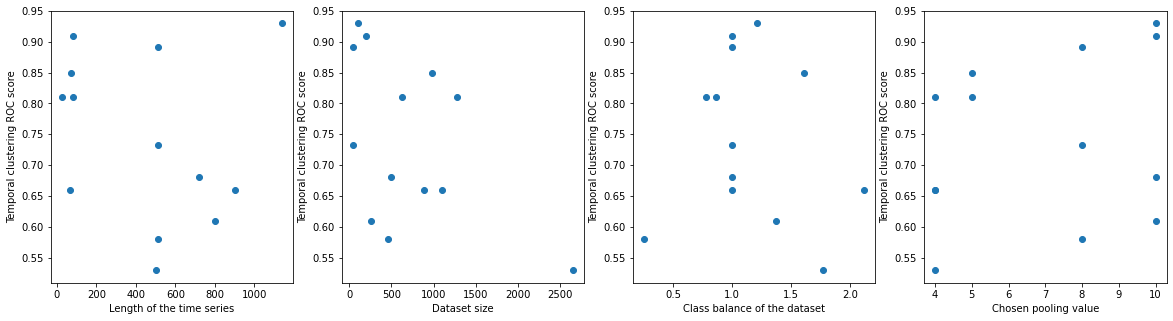

In [2]:
## These are results from the paper that we just visualize

max_scores = [0.93,0.892,0.732,0.68,0.58,0.81,0.91,0.61,0.529,0.66,0.85,0.81,0.66]
dataset_sizes = [104,40, 40, 500,461,1272,200,258,2658,891,980,621,1096]
ts_lengths = [1140, 512, 512, 720, 512, 84, 80, 800, 500, 64, 70, 24, 900]
dataset_r = [1.21,1.00,1.00,1.00,0.25,0.86,1.00,1.37,1.77,2.12,1.61,0.78,1]
dataset_p = [10,8,8,10,8,4,10,10,4,4,5,5,4]

fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax[0].scatter(ts_lengths, max_scores)
ax[0].set_xlabel('Length of the time series')
ax[0].set_ylabel('Temporal clustering ROC score')


ax[1].scatter(dataset_sizes, max_scores)
ax[1].set_xlabel('Dataset size')
ax[1].set_ylabel('Temporal clustering ROC score')

ax[2].scatter(dataset_r, max_scores)
ax[2].set_xlabel('Class balance of the dataset')
ax[2].set_ylabel('Temporal clustering ROC score')

ax[3].scatter(dataset_p, max_scores)
ax[3].set_xlabel('Chosen pooling value')
ax[3].set_ylabel('Temporal clustering ROC score')
plt.savefig('scatterplots.png')
plt.show()

## Encoder structures

In [ ]:
##Encoder with modifications

class TAE_encoder(nn.Module):
    """
    Class for temporal autoencoder encoder.
    filter_1 : filter size of the first convolution layer
    filter_rnn : hidden size of the rnn.
    pooling : pooling number for maxpooling.
    """

    def __init__(self, filter_1, filter_rnn, pooling):
        super().__init__()
        print('RNN encoder')
        self.hidden_rnn_1 = filter_rnn[0]
        self.hidden_rnn_2 = filter_rnn[1]
        self.pooling = pooling
        self.n_hidden = None
        ## CNN PART
        ### output shape (batch_size, 50 , n_hidden = 64)
        self.conv_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=filter_1,
                kernel_size=10,
                stride=1,
                padding=5,
            ),
            nn.LeakyReLU(),
            nn.MaxPool1d(self.pooling),
        )
        
        ###UNCOMMENT BELOW TO ADD ATTENTION LAYER
        #self.transformer = nn.TransformerEncoderLayer(
        #    d_model=50, 
        #    nhead = 2, 
        #)
        
        
        ## RNN PART, CAN BE EASILY CHANGED TO LSTM
        ### output shape (batch_size , n_hidden = 64 , 50)
        self.rnn_1 = nn.RNN(
            input_size=50,
            hidden_size=self.hidden_rnn_1,
            batch_first=True,
            bidirectional=True, 
            nonlinearity = 'relu'
        )

        ### output shape (batch_size , n_hidden = 64 , 1)
        self.rnn_2 = nn.RNN(
            input_size=50,
            hidden_size=self.hidden_rnn_2,
            batch_first=True,
            bidirectional=True, 
            nonlinearity = 'relu'
        )

    def forward(self, x):

        ## encoder
        out_cnn = self.conv_layer(x)
        out_cnn = out_cnn.permute((0, 2, 1))
        
        
        ###UNCOMMENT BELOW TO ADD ATTENTION LAYER
        #out_transformer = self.transformer(out_cnn)
        
        out_rnn1, _ = self.rnn_1(out_cnn)
        out_rnn1 = torch.sum(
            out_rnn1.view(
                out_rnn1.shape[0], out_rnn1.shape[1], 2, self.hidden_rnn_1
            ),
            dim=2,
        )
        features, _ = self.rnn_2(out_rnn1)
        features = torch.sum(
            features.view(
                features.shape[0], features.shape[1], 2, self.hidden_rnn_2
            ),
            dim=2,
        )  ## (batch_size , n_hidden ,1)
        if self.n_hidden == None:
            self.n_hidden = features.shape[1]
        return features


In [ ]:
## Code from existing implementation

class TAE(nn.Module):
    """
    Class for temporal autoencoder.
    filter_1 : filter size of the first convolution layer
    filter_lstm : hidden size of the lstm.
    """

    def __init__(self, args, filter_1=50, filter_lstm=[50, 1]):
        super().__init__()

        self.pooling = int(args.pool)
        self.filter_1 = filter_1
        self.filter_lstm = filter_lstm

        self.tae_encoder = TAE_encoder(
            filter_1=self.filter_1,
            filter_lstm=self.filter_lstm,
            pooling=self.pooling,
        )
        n_hidden = self.get_hidden(args.serie_size, args.device)
        args.n_hidden = n_hidden
        self.tae_decoder = TAE_decoder(
            n_hidden=args.n_hidden, pooling=self.pooling
        )

    def get_hidden(self, serie_size, device):
        a = torch.randn((1, 1, serie_size)).to(device)
        test_model = TAE_encoder(
            filter_1=self.filter_1,
            filter_lstm=self.filter_lstm,
            pooling=self.pooling,
        ).to(device)
        with torch.no_grad():
            _ = test_model(a)
        n_hid = test_model.n_hidden
        del test_model, a
        gc.collect()
        torch.cuda.empty_cache()
        return n_hid

    def forward(self, x):

        features = self.tae_encoder(x)
        out_deconv = self.tae_decoder(features)
        return features.squeeze(2), out_deconv


class ClusterNet(nn.Module):
    """
    class for the defintion of the DTC model
    path_ae : path to load autoencoder
    centr_size : size of the centroids = size of the hidden features
    alpha : parameter alpha for the t-student distribution.
    """

    def __init__(self, args):
        super().__init__()

        ## init with the pretrained autoencoder model
        self.tae = TAE(args)
        self.tae.load_state_dict(
            torch.load(args.path_weights_ae, map_location=args.device)
        )
        ## clustering model
        self.alpha_ = args.alpha
        self.centr_size = args.n_hidden
        self.n_clusters = args.n_clusters
        self.device = args.device
        self.similarity = args.similarity

    def init_centroids(self, x):
        """
        This function initializes centroids with agglomerative clustering
        + complete linkage.
        """
        z, _ = self.tae(x.squeeze().unsqueeze(1).detach())
        z_np = z.detach().cpu()
        assignements = AgglomerativeClustering(
            n_clusters=2, linkage="complete", affinity="precomputed"
        ).fit_predict(
            compute_similarity(z_np, z_np, similarity=self.similarity)
        )

        centroids_ = torch.zeros(
            (self.n_clusters, self.centr_size), device=self.device
        )

        for cluster_ in range(self.n_clusters):
            index_cluster = [
                k for k, index in enumerate(assignements) if index == cluster_
            ]
            centroids_[cluster_] = torch.mean(z.detach()[index_cluster], dim=0)

        self.centroids = nn.Parameter(centroids_)

    def forward(self, x):

        z, x_reconstr = self.tae(x)
        z_np = z.detach().cpu()

        similarity = compute_similarity(
            z, self.centroids, similarity=self.similarity
        )

        ## Q (batch_size , n_clusters)
        Q = torch.pow((1 + (similarity / self.alpha_)), -(self.alpha_ + 1) / 2)
        sum_columns_Q = torch.sum(Q, dim=1).view(-1, 1)
        Q = Q / sum_columns_Q

        ## P : ground truth distribution
        P = torch.pow(Q, 2) / torch.sum(Q, dim=0).view(1, -1)
        sum_columns_P = torch.sum(P, dim=1).view(-1, 1)
        P = P / sum_columns_P
        return z, x_reconstr, Q, P

In [2]:
def pretrain_autoencoder(args, verbose=True):
    """
    function for the autoencoder pretraining
    """
    print("Pretraining autoencoder... \n")

    ## define TAE architecture
    tae = TAE(args)
    tae = tae.to(args.device)

    ## MSE loss
    loss_ae = nn.MSELoss()
    ## Optimizer
    optimizer = torch.optim.Adam(tae.parameters(), lr=args.lr_ae)
    tae.train()

    for epoch in range(args.epochs_ae):
        all_loss = 0
        for batch_idx, (inputs, _) in enumerate(trainloader):
            inputs = inputs.type(torch.FloatTensor).to(args.device)
            optimizer.zero_grad()
            z, x_reconstr = tae(inputs)
            loss_mse = loss_ae(inputs.squeeze(1), x_reconstr)

            loss_mse.backward()
            all_loss += loss_mse.item()
            optimizer.step()
        if verbose:
            print(
                "Pretraining autoencoder loss for epoch {} is : {}".format(
                    epoch, all_loss / (batch_idx + 1)
                )
            )

    print("Ending pretraining autoencoder. \n")
    # save weights
    torch.save(tae.state_dict(), args.path_weights_ae)


def initalize_centroids(X):
    """
    Function for the initialization of centroids.
    """
    X_tensor = torch.from_numpy(X).type(torch.FloatTensor).to(args.device)
    model.init_centroids(X_tensor)


def kl_loss_function(input, pred):
    out = input * torch.log((input) / (pred))
    return torch.mean(torch.sum(out, dim=1))


def train_ClusterNET(epoch, args, verbose):
    """
    Function for training one epoch of the DTC
    """
    model.train()
    train_loss = 0
    all_preds, all_gt = [], []
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.type(torch.FloatTensor).to(args.device)
        all_gt.append(labels.cpu().detach())
        optimizer_clu.zero_grad()
        z, x_reconstr, Q, P = model(inputs)
        loss_mse = loss1(inputs.squeeze(), x_reconstr)
        loss_KL = kl_loss_function(P, Q)

        total_loss = loss_mse + loss_KL
        total_loss.backward()
        optimizer_clu.step()

        preds = torch.max(Q, dim=1)[1]
        all_preds.append(preds.cpu().detach())
        train_loss += total_loss.item()
    if verbose:
        print(
            "For epoch ",
            epoch,
            " Loss is : %.3f" % (train_loss / (batch_idx + 1)),
        )
    all_gt = torch.cat(all_gt, dim=0).numpy()
    all_preds = torch.cat(all_preds, dim=0).numpy()
    return (
        preds.detach().cpu().numpy(),
        max(
            roc_auc_score(all_gt, all_preds),
            roc_auc_score(all_gt, 1 - all_preds),
        ),
        train_loss / (batch_idx + 1),
    )


def training_function(args, verbose=True):

    """
    function for training the DTC network.
    """
    ## initialize clusters centroids
    initalize_centroids(X_scaled)

    ## train clustering model
    max_roc_score = 0
    print("Training full model ...")
    for epoch in range(args.max_epochs):
        preds, roc_score, train_loss = train_ClusterNET(
            epoch, args, verbose=verbose
        )
        if roc_score > max_roc_score:
            max_roc_score = roc_score
            patience = 0
        else:
            patience += 1
            if patience == args.max_patience:
                args.lr_ae/=10
                args.lr_cluster/=10

    torch.save(model.state_dict(), args.path_weights_main)
    return max_roc_score


In [7]:
##Code modified from existing repo to plot our experiments

n_trials = 1
n_epochs_list = [2, 4, 6, 8, 10, 12, 14, 16]
scores = np.zeros((len(n_epochs_list), n_trials))

for idx, n_epochs_ae in enumerate(n_epochs_list):
    avg_roc = 0
    for i in range(n_trials):
        parser = get_arguments()
        args = parser.parse_args("--pool 5 --similarity DTW --epochs_ae {} --max_patience 10"\
                                 .format(n_epochs_ae).split()) #use similarity = CID for faster results
        args.path_data = args.path_data.format(args.dataset_name)
        args.batch_size = 16
        args.lr_ae = 1e-2
        args.lr_cluster = 1e-2
        if not os.path.exists(args.path_data):
            os.makedirs(args.path_data)

        path_weights = args.path_weights.format(args.dataset_name)
        if not os.path.exists(path_weights):
            os.makedirs(path_weights)

        args.path_weights_ae = os.path.join(path_weights, "autoencoder_weight.pth")
        args.path_weights_main = os.path.join(
            path_weights, "full_model_weigths.pth"
        )

        args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        trainloader, X_scaled = get_loader(args)
        pretrain_autoencoder(args)

        model = ClusterNet(args)
        model = model.to(args.device)
        loss1 = nn.MSELoss()
        optimizer_clu = torch.optim.SGD(
            model.parameters(), lr=args.lr_cluster, momentum=args.momentum
        )

        max_roc_score = training_function(args)
        avg_roc += max_roc_score
        print("________________maximum roc score is {}___________________".format(max_roc_score))
        scores[idx, i] = max_roc_score

    
    print("average roc score is {}".format(avg_roc/n_trials))

Pretraining autoencoder... 

Pretraining autoencoder loss for epoch 0 is : 0.6221394011607537
Pretraining autoencoder loss for epoch 1 is : 0.28872242646339613
Ending pretraining autoencoder. 

Training full model ...
For epoch  0  Loss is : 0.243
For epoch  1  Loss is : 0.237
For epoch  2  Loss is : 0.232
For epoch  3  Loss is : 0.228
For epoch  4  Loss is : 0.224
For epoch  5  Loss is : 0.221
For epoch  6  Loss is : 0.217
For epoch  7  Loss is : 0.215
For epoch  8  Loss is : 0.212
For epoch  9  Loss is : 0.210
For epoch  10  Loss is : 0.207
For epoch  11  Loss is : 0.205
For epoch  12  Loss is : 0.203
For epoch  13  Loss is : 0.202
For epoch  14  Loss is : 0.200
For epoch  15  Loss is : 0.199
For epoch  16  Loss is : 0.197
For epoch  17  Loss is : 0.196
For epoch  18  Loss is : 0.194
For epoch  19  Loss is : 0.193
For epoch  20  Loss is : 0.192
For epoch  21  Loss is : 0.191
For epoch  22  Loss is : 0.190
For epoch  23  Loss is : 0.189
For epoch  24  Loss is : 0.188
For epoch  25  Lo

Pretraining autoencoder... 

Pretraining autoencoder loss for epoch 0 is : 0.37942696229005474
Pretraining autoencoder loss for epoch 1 is : 0.24958360500824758
Pretraining autoencoder loss for epoch 2 is : 0.1923550138106713
Pretraining autoencoder loss for epoch 3 is : 0.16322985692666128
Pretraining autoencoder loss for epoch 4 is : 0.14450387007150894
Pretraining autoencoder loss for epoch 5 is : 0.1298819608413256
Pretraining autoencoder loss for epoch 6 is : 0.11848947081046227
Pretraining autoencoder loss for epoch 7 is : 0.11151599807616992
Pretraining autoencoder loss for epoch 8 is : 0.10477542017514889
Pretraining autoencoder loss for epoch 9 is : 0.10107394651724742
Ending pretraining autoencoder. 



KeyboardInterrupt: 

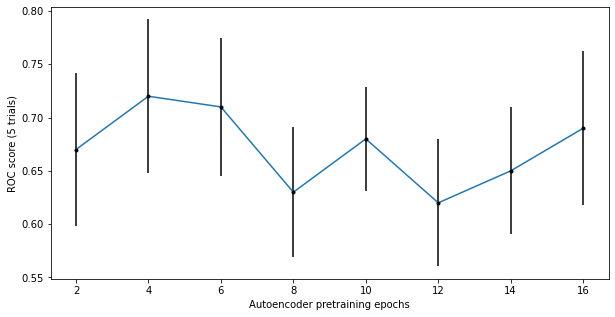

In [8]:
plt.figure(figsize=(10,5))
plt.plot(n_epochs_list, scores.mean(axis=1))
plt.errorbar(n_epochs_list, scores.mean(axis=1), yerr=scores.std(axis=1), fmt='.k')
plt.xlabel('Autoencoder pretraining epochs')
plt.ylabel('ROC score ({} trials)'.format(n_trials))
#plt.title('Scores varying with autoencoder pretraining for the model with DTW similarity')
plt.savefig('DTW.png')